In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis (EDA)

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- `charges` has very different **mean** and **median** values, indicating possible skew
- all other data quality quick checks appear in reasonably normal ranges

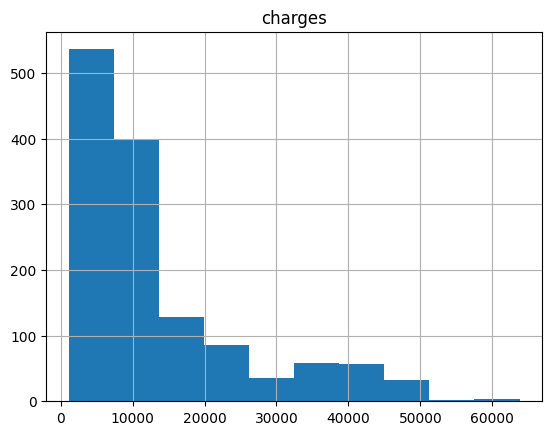

In [5]:
insurance.hist('charges')
plt.show()

The `charges` column is,in fact, highly skewed to the right. Extremely costly insurance charges are less common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

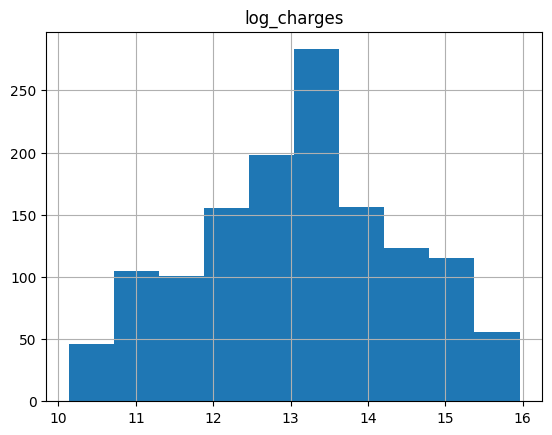

In [6]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")
plt.show()

## Feature Selection

In [7]:
correlations = insurance.corr()
correlations

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


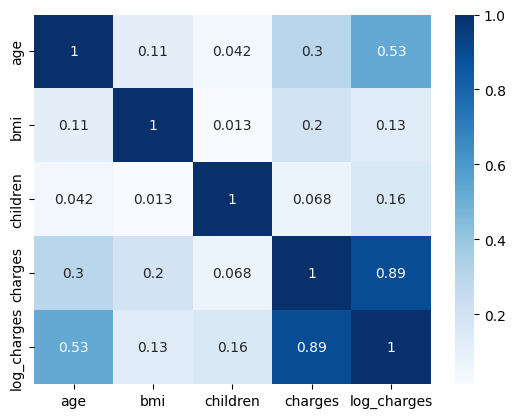

In [8]:
sns.heatmap(correlations, cmap='Blues', annot=True)
plt.show()

- `age` has 30% correlation with charges
- `bmi` has 20% correlation
- `children` has 6.7% correlation

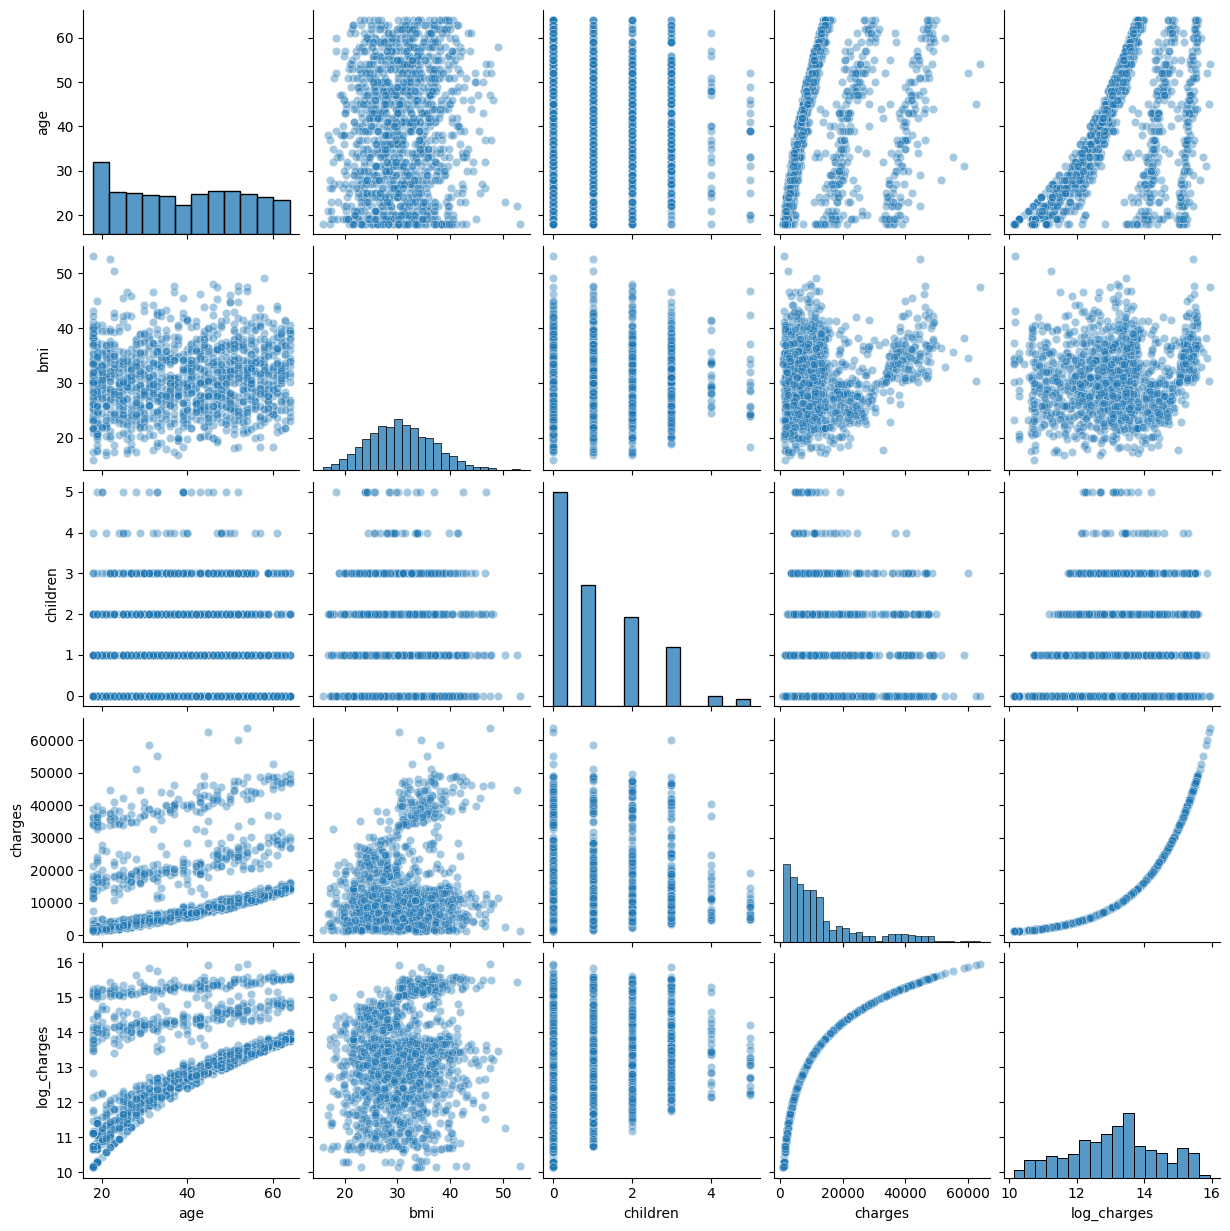

In [97]:
insurance_numeric = insurance[['age', 'bmi', 'children', 'charges', 'log_charges']]
sns.pairplot(insurance_numeric, kind='scatter', plot_kws={'alpha': 0.4})

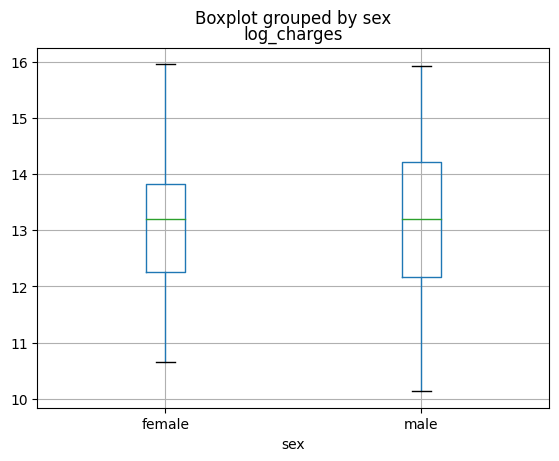

In [10]:
insurance.boxplot(column=["log_charges"], by="sex")
plt.show()

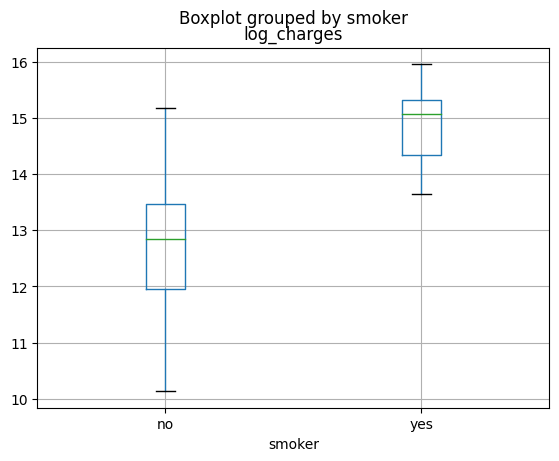

In [11]:
insurance.boxplot(column=["log_charges"], by="smoker")
plt.show()

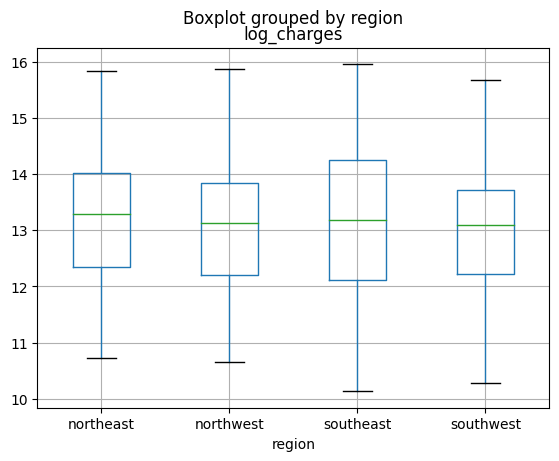

In [12]:
insurance.boxplot(column=["log_charges"], by="region")
plt.show()

- Males seem to have a wider distribution of charges compared to women.
- Smokers have much higher costs than non-smokers.
- There doesn't seem tobe many appreciable differences between regions.

### Determining the features:
Based on the univariate relationships shown above, `age`, `bmi`, and `smoker`are positively associated with higher charges. We'll include these predictors in our final model.

## Dividing the Data

In [13]:
# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
# insurance["is_male"] = (insurance['sex'] == 'male')
# insurance['is_west'] = ((insurance['region'] == 'northwest') | (insurance['region'] == 'southwest'))
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)

## Building the Model

In [14]:
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)
insurance_model.coef_

array([0.0508618 , 0.01563733, 2.23214787])

In [15]:
y_pred = insurance_model.predict(X_train)

In [16]:
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.44791919632992105

In [17]:
# MSE on the original scale for the insurance charges
train_mse_orig_scale = np.exp(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

1.565052228580154

In [18]:
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7433336007728248

The training MSE for the model is 0.448 and is 1.57 on the original scale. The `r2` indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

## Residual Diagnostics

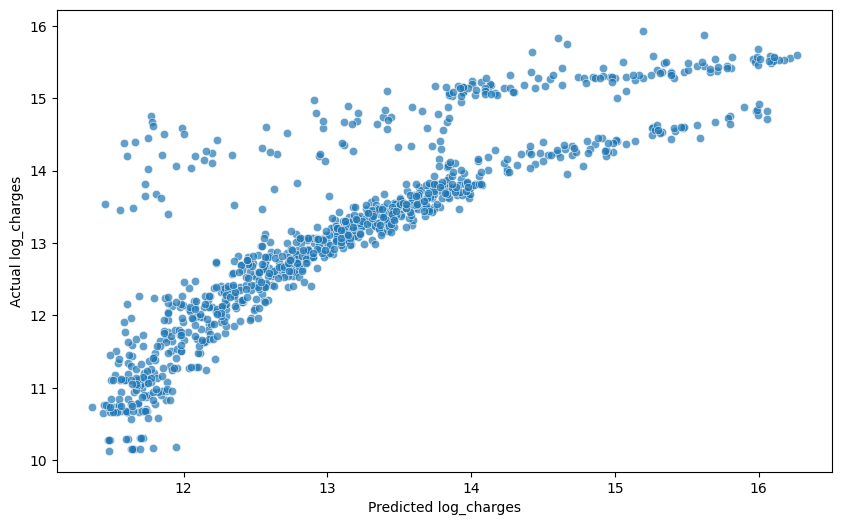

In [19]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'is_smoker': X_train['is_smoker'],
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

<AxesSubplot:xlabel='predictions', ylabel='residuals'>

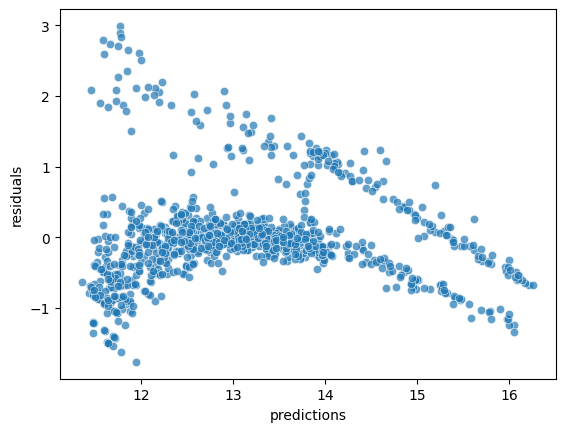

In [20]:
sns.scatterplot(x='predictions', y='residuals', 
                data=plot_df, alpha=0.7)

The residuals suggest some violations to the assumptions of linear regression. As predicted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

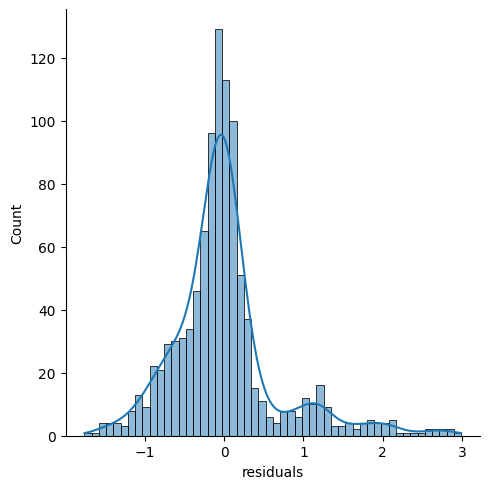

In [21]:
sns.displot(plot_df['residuals'], kde=True)

## Interpreting the Model

In [22]:
cdf = pd.DataFrame(insurance_model.coef_, X.columns, columns=['Coef'])
print(cdf)

               Coef
age        0.050862
bmi        0.015637
is_smoker  2.232148


In [23]:
insurance_model.intercept_

10.199942936238687

**Translating this into a "concept"**  
Note that this is just to exemplify what the linear regression equation would look like for demonstrations purposes.

$$charges = 0.05 \times age + 0.016 \times bmi + 2.232 \times is\_smoker + 10.2$$

## Final Model Evaluation

In [24]:
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4529281560931769

In [33]:
# Putting the outcome (in log-terms) back into the original scale
np.exp2(mean_squared_error(y_test, test_pred))

1.368815646563475

## Segmenting by smoker status

In [87]:
smokers_df = insurance[insurance["is_smoker"] == True]

In [88]:
X = smokers_df[["age", "bmi"]]
y = smokers_df["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)

In [89]:
smoker_model = LinearRegression()
smoker_model.fit(X_train, y_train)
smoker_model.coef_

array([0.01282851, 0.07098738])

In [90]:
y_pred = smoker_model.predict(X_train)

In [91]:
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.07046354357369704

In [92]:
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7661650418251628

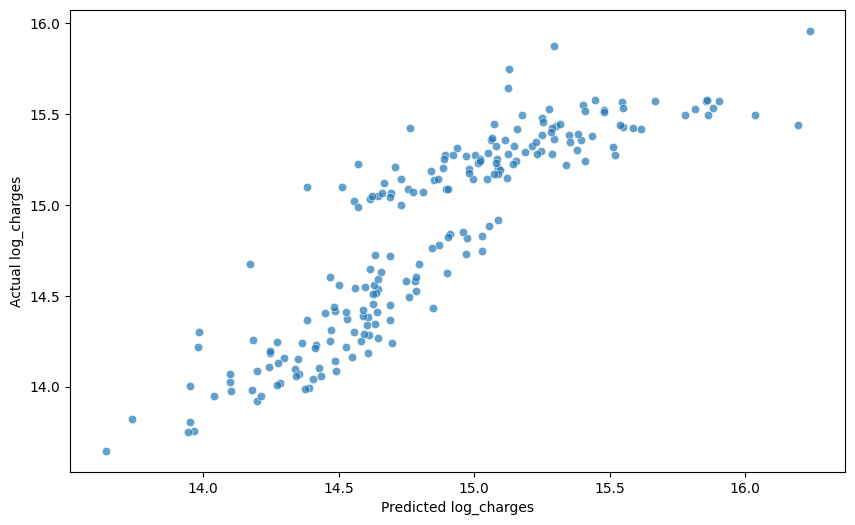

In [93]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

<AxesSubplot:xlabel='predictions', ylabel='residuals'>

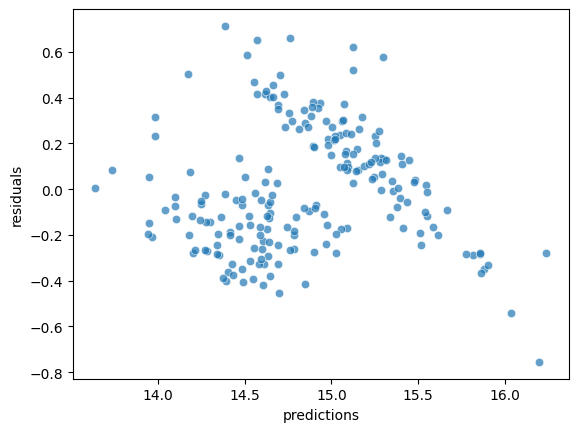

In [95]:
sns.scatterplot(x='predictions', y='residuals', 
                data=plot_df, alpha=0.7)

In [96]:
test_pred = smoker_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.09416078156173782

### A model experiment (to see if residual distribution improves)

In [26]:
# Add interaction terms
X_train_interaction = X_train.copy()
X_train_interaction['age_smoker'] = X_train['age'] * X_train['is_smoker']
X_train_interaction['bmi_smoker'] = X_train['bmi'] * X_train['is_smoker']
X_train_interaction['bmi_age'] = X_train['bmi'] * X_train['age']
X_train_interaction['big_age'] = X_train['age']**2
X_train_interaction['big_bmi'] = X_train['bmi']**2

   
# Train new model with interactions
model_with_interactions = LinearRegression()
model_with_interactions.fit(X_train_interaction, y_train)

LinearRegression()

In [27]:
y_pred_with_interaction = model_with_interactions.predict(X_train_interaction)
len(y_train)

1003

<AxesSubplot:xlabel='predictions', ylabel='actual'>

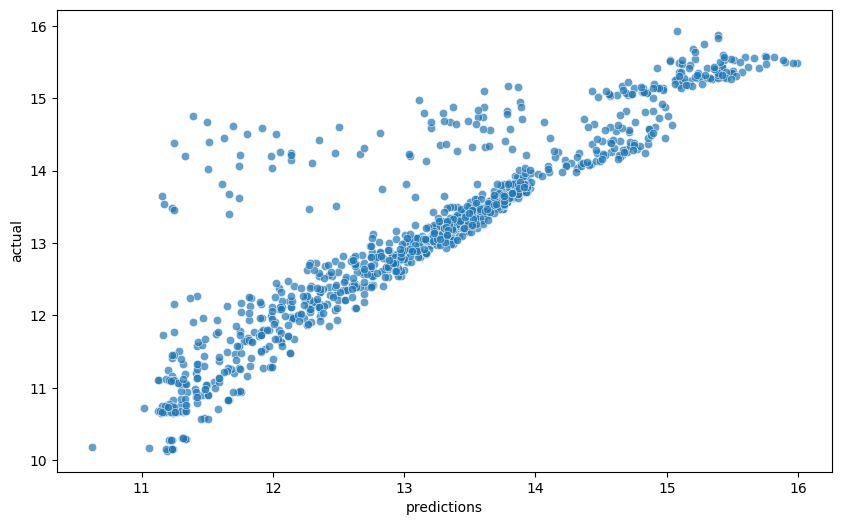

In [28]:
plot_df = pd.DataFrame({
    'predictions': y_pred_with_interaction,
    'actual': y_train,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7,)

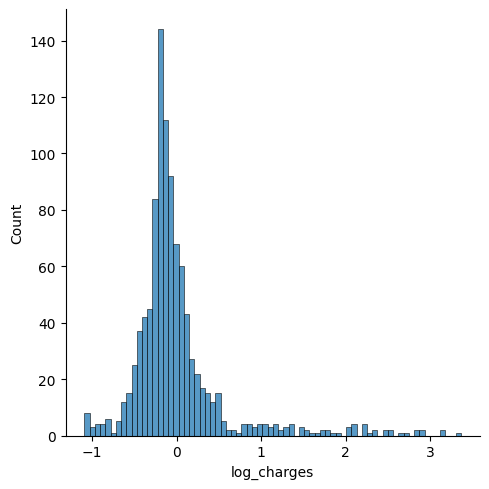

In [29]:
interaction_residuals = y_train - y_pred_with_interaction
sns.displot(interaction_residuals)

In [30]:
train_mse = mean_squared_error(y_train, y_pred_with_interaction)
train_mse

0.33280245787764956

In [32]:
np.exp2(0.05*30 + 0.016*20 + 2.232 + 10.2)

19510.998619995626